In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, precision_recall_fscore_support
)

RANDOM_STATE = 42

# loading primary dataset
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Target & features
TARGET = "Diabetes_binary"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

def evaluate(model, X_test, y_test, name="Model"):
    """Prints core metrics and returns a dict for logging/aggregation."""
    y_pred = model.predict(X_test)
    # For binary problems we can compute ROC-AUC on probabilities:
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    print(f"\n{name} — Classification report")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    if not np.isnan(auc):
        print(f"ROC-AUC: {auc:.4f}")

    return {
        "model": name,
        "roc_auc": auc,
        **{
            f"f1_{label}": f1
            for label, f1 in zip(
                sorted(np.unique(y_test)),
                precision_recall_fscore_support(y_test, y_pred, average=None)[2]
            )
        }
    }

In [11]:
!pip install xgboost

In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",       # 'logloss' for binary, 'mlogloss' for multi
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
xgb_metrics = evaluate(xgb, X_test, y_test, "XGBoost")


XGBoost — Classification report
              precision    recall  f1-score   support

           0     0.7769    0.7079    0.7408      7070
           1     0.7317    0.7967    0.7628      7069

    accuracy                         0.7523     14139
   macro avg     0.7543    0.7523    0.7518     14139
weighted avg     0.7543    0.7523    0.7518     14139

Confusion matrix:
 [[5005 2065]
 [1437 5632]]
ROC-AUC: 0.8304


In [18]:
param_grid = {
    "n_estimators": [300, 500, 800],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid, scoring="f1_macro", cv=3, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
evaluate(best_xgb, X_test, y_test, "XGBoost (Tuned)")


XGBoost (Tuned) — Classification report
              precision    recall  f1-score   support

           0     0.7791    0.7068    0.7412      7070
           1     0.7317    0.7995    0.7641      7069

    accuracy                         0.7532     14139
   macro avg     0.7554    0.7532    0.7526     14139
weighted avg     0.7554    0.7532    0.7526     14139

Confusion matrix:
 [[4997 2073]
 [1417 5652]]
ROC-AUC: 0.8302


{'model': 'XGBoost (Tuned)',
 'roc_auc': 0.8302396982822183,
 'f1_0': 0.741174725600712,
 'f1_1': 0.7640935514397729}

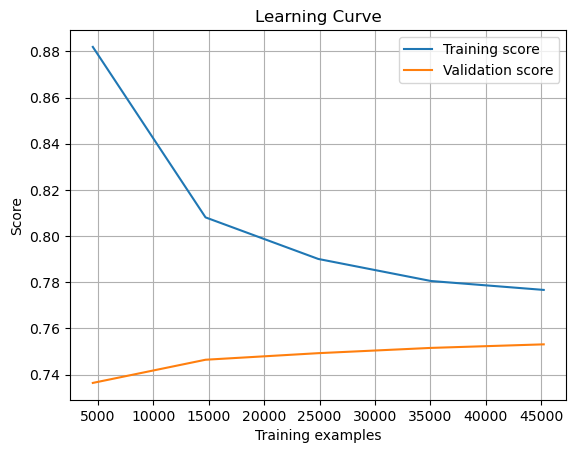

In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(xgb, X_train, y_train, cv=5)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Validation score")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()


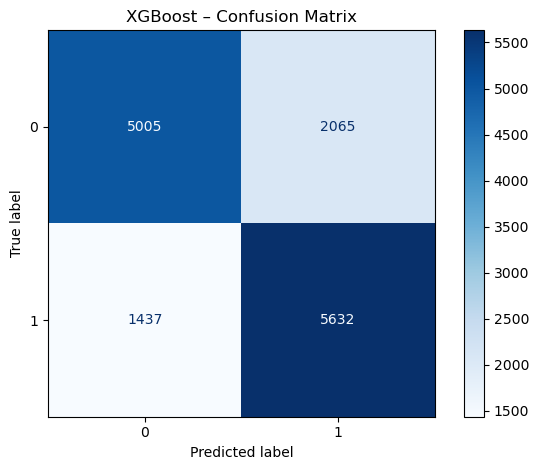

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = xgb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("XGBoost – Confusion Matrix")
plt.tight_layout()
plt.show()


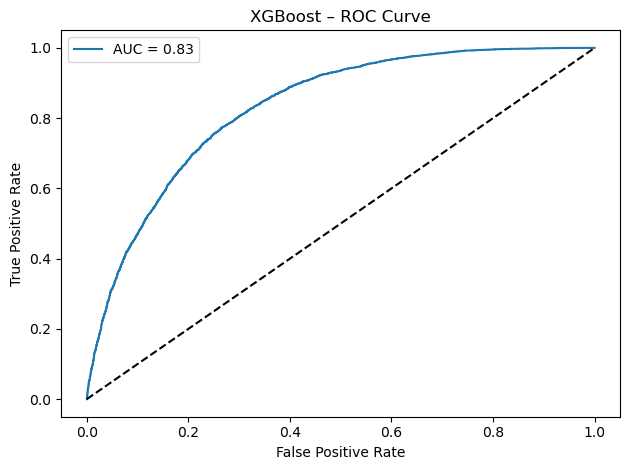

In [30]:
IS_BINARY = True

# running ROC curve
y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost – ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

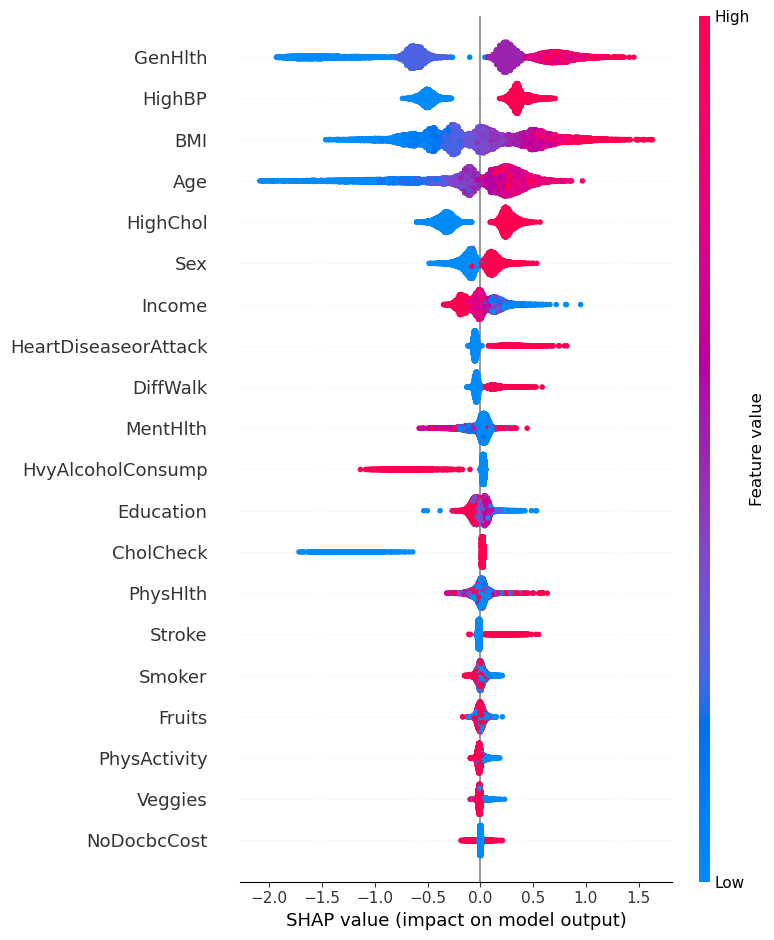

In [26]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)